In [ ]:
%pip install --upgrade --quiet sentence-transformers

In [ ]:
%pip install --upgrade --quiet seaborn

For clustering, we can either load the articles and use the Hugging Face Sentence Tranformer API to gennerate embeddings for the paper abstracts, using an embedding model of choice, or we can use the embeddings generated for our vector database in notebooks 3.x.

In [5]:
import pandas as pd
from genscai import paths

df_modeling_papers = pd.read_json(paths.data / "modeling_papers_0.json", orient="records", lines=True)
df_modeling_papers.shape

# only use thef first 100 documents for testing
documents = df_modeling_papers.get("abstract").tolist()[:100]

Use Hugging Face Sentence Transformer to generate embeddings for the paper abstracts.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/allenai-specter")
embeddings = model.encode(documents)

Instead of (re)generating embeddings using the Sentence Transformer API, we can load embeddings from our vector data store.

In [6]:
import chromadb
from genscai import paths

client = chromadb.PersistentClient(path=str(paths.output / "chroma_db"))

collection_name = "papers-default-embeddings"
collection = client.get_collection(name=collection_name)

embeddings = collection.get(include=["embeddings"])["embeddings"]

print(f"retrieved {len(embeddings)} paper embeddings")

retrieved 100 paper embeddings


Use t-SNE to reduce dimensionality of the embeddings to two, for 2d visualization.

In [7]:
from sklearn.manifold import TSNE

tsne_embeddings = TSNE(n_components=2, perplexity=5, max_iter=10000).fit_transform(embeddings)

In [8]:
from sklearn.cluster import KMeans

X = tsne_embeddings

model = KMeans(n_clusters=6).fit(X)
centers = model.cluster_centers_
labels = model.labels_.astype(float)

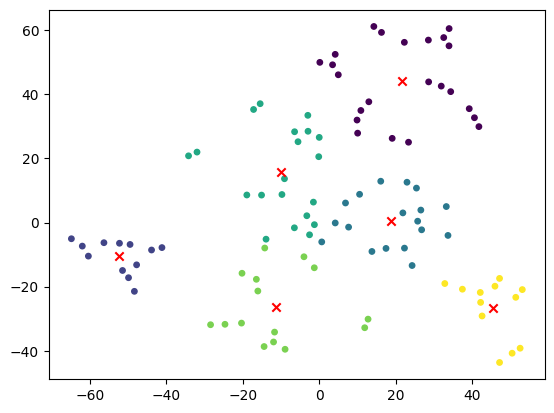

In [9]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=labels, s=15)
plt.scatter(centers[:, 0], centers[:, 1], marker="x", color="red")
plt.show()

<Axes: >

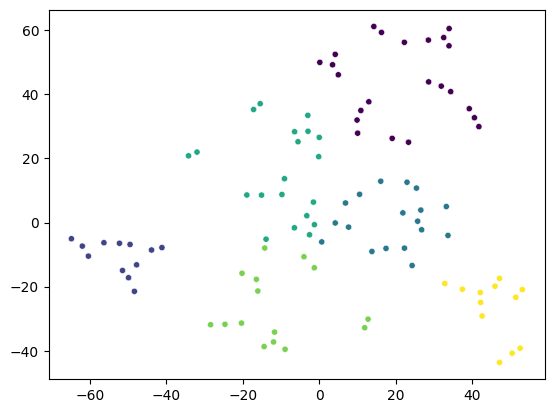

In [10]:
import seaborn as sns

sns.scatterplot(x=X[:, 0], y=X[:, 1], s=20, c=labels)

In [11]:
from sklearn.decomposition import PCA

model = PCA(n_components=2).fit(embeddings)
pca_embeddings = model.transform(embeddings)

In [12]:
from sklearn.cluster import KMeans

X = pca_embeddings

model = KMeans(n_clusters=5).fit(X)
centers = model.cluster_centers_
labels = model.labels_.astype(float)

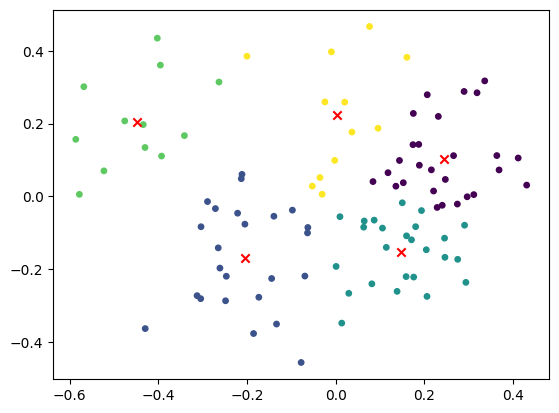

In [13]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=labels, s=15)
plt.scatter(centers[:, 0], centers[:, 1], marker="x", color="red")
plt.show()

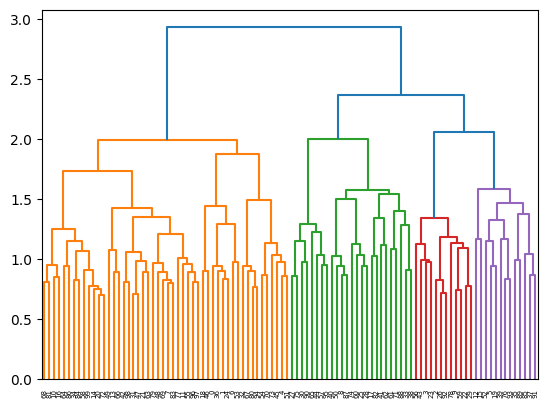

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(embeddings, method="ward")

dendrogram(Z)
plt.show()

In [15]:
from scipy.cluster.hierarchy import fcluster

labels = fcluster(Z, 8, criterion="maxclust")

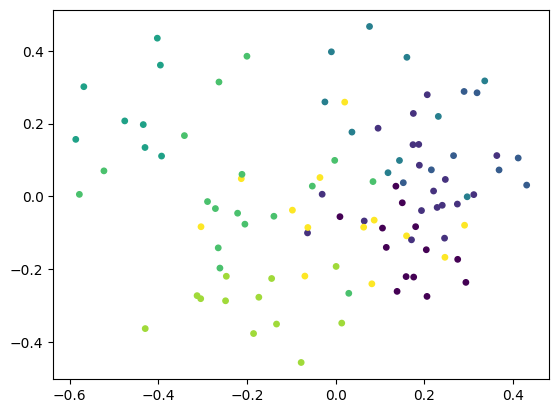

In [16]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=15)
plt.show()

In [17]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=7, linkage="ward")
model.fit(X)

labels = model.labels_

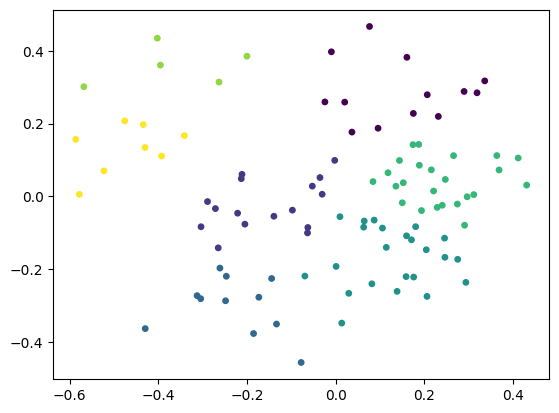

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=15)
plt.show()

Re-run the clustering analysis using the default Chroma embedding model.

In [19]:
collection_name = "papers-default-embeddings-cosign-distance"
collection = client.get_collection(name=collection_name)

embeddings = collection.get(include=["embeddings"])["embeddings"]

print(f"retrieved {len(embeddings)} paper embeddings")

retrieved 100 paper embeddings


In [20]:
from sklearn.manifold import TSNE

tsne_embeddings = TSNE(n_components=2, perplexity=5, max_iter=10000).fit_transform(embeddings)

In [21]:
from sklearn.cluster import KMeans

X = tsne_embeddings

model = KMeans(n_clusters=7).fit(X)
centers = model.cluster_centers_
labels = model.labels_.astype(float)

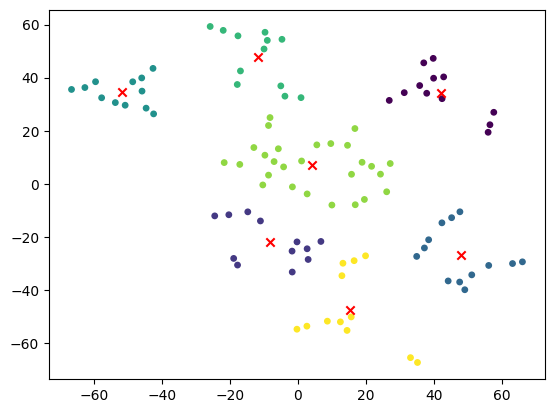

In [22]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=labels, s=15)
plt.scatter(centers[:, 0], centers[:, 1], marker="x", color="red")
plt.show()